# Signal generation example
Demonstrate the generation and manipulation of time series signals

S. Jones (06/11/25)

In [103]:
from CRESSignalStructure.Particle import Particle
from CRESSignalStructure.NumericalSpectrumCalculator import NumericalSpectrumCalculator
from CRESSignalStructure.RealFields import HarmonicField
from CRESSignalStructure.CircularWaveguide import CircularWaveguide
from CRESSignalStructure.SignalGenerator import SignalGenerator
import numpy as np
import scipy.constants as sc
import matplotlib.pyplot as plt

In [104]:
# Allow LaTeX in figure labels
plt.rcParams['text.usetex'] = True
plt.rc('font', family='serif')

Start off by defining a harmonic trap along with a suitable electron and a waveguide.

In [105]:
TRAP_DEPTH = 4e-3  # Tesla
B0 = 1.0           # Tesla
R_COIL = 1.25e-2   # metres
I_COIL = 2 * TRAP_DEPTH * R_COIL / sc.mu_0  # Amperes
field = HarmonicField(radius=R_COIL, current=I_COIL, background=B0)

E_KIN = 18.6e3  # eV
PITCH_ANGLE = 89.8 * np.pi / 180  # radians
particle = Particle(E_KIN, np.zeros(3), pitchAngle=PITCH_ANGLE)

R_WG = 5e-3  # metres
wg = CircularWaveguide(radius=R_WG)

In [106]:
spec = NumericalSpectrumCalculator(field, wg, particle)

We should now calculate an appropriate local oscillator frequency, such that our baseband is well below the Nyquist frequency of our digitizer.

In [107]:
F_DIGITIZER = 1e9                                     # Hertz
LO_FREQ = spec.GetPeakFrequency(0) - F_DIGITIZER / 4  # Hertz

In [108]:
# Start by generating a signal about 10us long
T_ACQ = 40e-6
sigGen = SignalGenerator(spec, F_DIGITIZER, LO_FREQ, T_ACQ)
MAX_ORDER = 8
t, signalShort = sigGen.GenerateSignal(MAX_ORDER)

(0.0, 0.05)

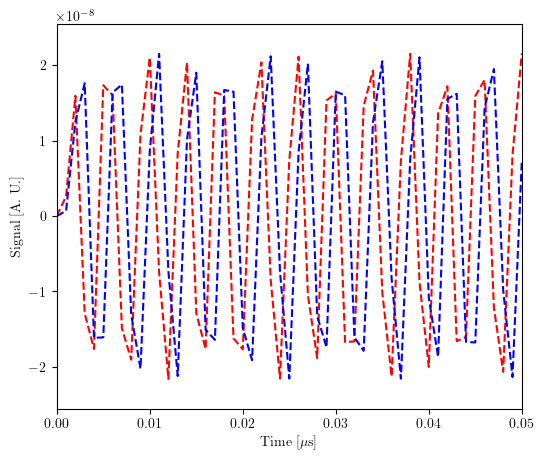

In [109]:
fig, ax = plt.subplots(1, 1, figsize=(6,5))
ax.plot(t * 1e6, np.real(signalShort), 'r--', label='Real')
ax.plot(t * 1e6, np.imag(signalShort), 'b--', label='Imaginary')
ax.set_xlabel(r"Time [$\mu$s]")
ax.set_ylabel("Signal [A. U.]")
ax.set_xlim(0, 0.05)

3.715708546159131e-07
(-3.7666101739226797e-07+5.1626474530771135e-08j)


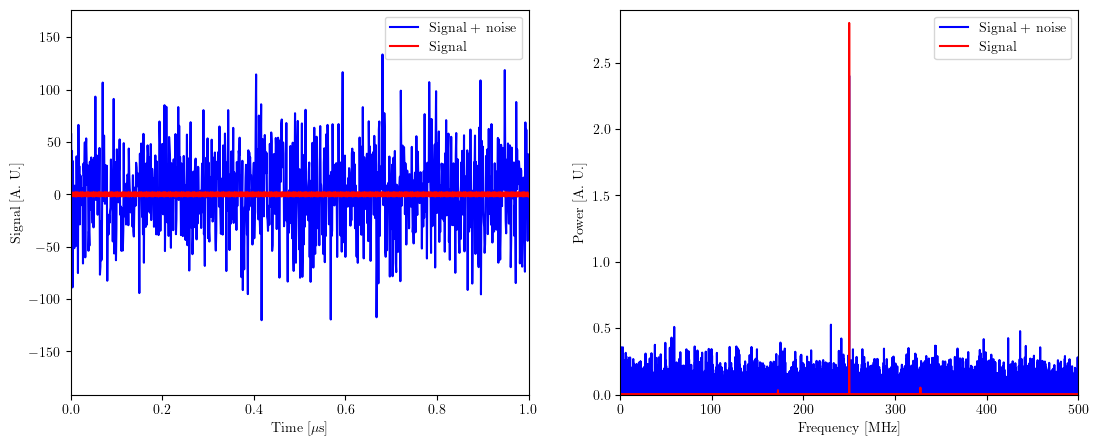

In [110]:
# Plot the FFT of this signal
import scipy.fft

SCALE_FACTOR = 1e8

sigFFT = scipy.fft.fft(signalShort * SCALE_FACTOR, norm='forward')
sigFFTfreqs = scipy.fft.fftfreq(len(signalShort), 1 / F_DIGITIZER)

noiseT = 10.0  # Kelvin
sigma = np.sqrt(sc.k * F_DIGITIZER * noiseT)
print(sigma)
noise = np.random.normal(loc=0, scale=sigma, size=len(signalShort)) + 1j * np.random.normal(loc=0, scale=sigma/np.sqrt(2), size=len(signalShort))
print(noise[6])
sigPlusNoise = signalShort + noise
sigPlusNoiseFFT = scipy.fft.fft(sigPlusNoise * SCALE_FACTOR, norm='forward')

fig, ax = plt.subplots(1, 2, figsize=(13, 5))
ax[0].plot(t*1e6, np.real(sigPlusNoise) * SCALE_FACTOR, 'b-', label='Signal + noise')
ax[0].plot(t*1e6, np.real(signalShort) * SCALE_FACTOR, 'r-', label='Signal')
ax[0].set_xlabel(r'Time [$\mu$s]')
ax[0].set_ylabel('Signal [A. U.]')
ax[0].set_xlim(0, 1)
ax[0].legend()

ax[1].plot(sigFFTfreqs/1e6, np.abs(sigPlusNoiseFFT)**2, 'b-', label='Signal + noise')
ax[1].plot(sigFFTfreqs / 1e6, np.abs(sigFFT)**2, 'r-', label='Signal')
ax[1].set_xlabel('Frequency [MHz]')
ax[1].set_ylabel('Power [A. U.]')
ax[1].set_xlim(0, 500)
ax[1].set_ylim(0, 2.9)
ax[1].legend()

plt.savefig('HighPitchAngle.pdf', bbox_inches='tight')